In [107]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import skops.io as sio
import torch

from itertools import combinations

from scipy.io import arff
from scipy.stats import ttest_ind, ttest_1samp
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from classifier import FeatureExtractor
from classifier import train_model, test_model

np.random.seed(0)

На датасете [Ham](https://www.timeseriesclassification.com/description.php?Dataset=Ham) протестирован метод классификации временных рядов, представленный в [Dempster et al: exceptionally fast and accurate time series classification using random convolutional kernels](https://arxiv.org/abs/1910.13051). Сравним результаты с полученной в статье тестовой $accuracy = 0.7257.$

Метод состоит в следующем: на основе большого числа случайных (но фиксированных при обучении) сверток генерируется вектор признаков, к которому затем применяется линейный классификатор. 

В этом ноутбуке сравниваются 3 способа генерации весов случайных сверток: на основе 1) нормального распределения, 2) случайного выбора из $[-1, 1]$, 3) случайного выбора из $[-1, 0, 1].$ Остальные параметры зафиксированы как в статье.

# Загрузка и предобработка данных

Обзор структуры, проверка на наличие пропущенных значений и перевод в формат, который может принять модель.

In [2]:
train = arff.loadarff("Ham/Ham_TRAIN.arff")
train = pd.DataFrame(train[0])
train = train.sample(frac=1)
train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att423,att424,att425,att426,att427,att428,att429,att430,att431,target
84,-0.678676,-0.692275,-0.700148,-0.701222,-0.700506,-0.696927,-0.689412,-0.679392,-0.669729,-0.661140,...,0.363438,0.120087,-0.091056,-0.255675,-0.373772,-0.452503,-0.499742,-0.521572,-0.526224,b'2'
10,-0.664186,-0.639378,-0.601115,-0.543510,-0.476235,-0.434188,-0.421573,-0.421573,-0.429983,-0.451006,...,-0.329070,-0.582614,-0.739450,-0.818499,-0.847091,-0.852978,-0.842466,-0.812612,-0.784441,b'1'
75,-0.721131,-0.659126,-0.623255,-0.669375,-0.752389,-0.772887,-0.766225,-0.765713,-0.781086,-0.798509,...,0.586096,0.263261,-0.049326,-0.320918,-0.515644,-0.633504,-0.690385,-0.710882,-0.718569,b'2'
2,-0.695711,-0.702015,-0.695317,-0.677191,-0.640544,-0.558976,-0.436034,-0.365105,-0.361165,-0.392688,...,-0.392688,-0.455736,-0.530605,-0.606262,-0.684677,-0.760334,-0.818653,-0.852147,-0.865545,b'1'
24,-0.925798,-0.905106,-0.887431,-0.886138,-0.891311,-0.903381,-0.915452,-0.920194,-0.920194,-0.919332,...,0.656295,0.134678,-0.223125,-0.447290,-0.574892,-0.643866,-0.671456,-0.681802,-0.683958,b'1'


In [3]:
train.isnull().sum().unique()

array([0])

In [4]:
train.target.unique()

array([b'2', b'1'], dtype=object)

In [5]:
train.target = train.target.astype(int)

In [6]:
train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att423,att424,att425,att426,att427,att428,att429,att430,att431,target
84,-0.678676,-0.692275,-0.700148,-0.701222,-0.700506,-0.696927,-0.689412,-0.679392,-0.669729,-0.661140,...,0.363438,0.120087,-0.091056,-0.255675,-0.373772,-0.452503,-0.499742,-0.521572,-0.526224,2
10,-0.664186,-0.639378,-0.601115,-0.543510,-0.476235,-0.434188,-0.421573,-0.421573,-0.429983,-0.451006,...,-0.329070,-0.582614,-0.739450,-0.818499,-0.847091,-0.852978,-0.842466,-0.812612,-0.784441,1
75,-0.721131,-0.659126,-0.623255,-0.669375,-0.752389,-0.772887,-0.766225,-0.765713,-0.781086,-0.798509,...,0.586096,0.263261,-0.049326,-0.320918,-0.515644,-0.633504,-0.690385,-0.710882,-0.718569,2
2,-0.695711,-0.702015,-0.695317,-0.677191,-0.640544,-0.558976,-0.436034,-0.365105,-0.361165,-0.392688,...,-0.392688,-0.455736,-0.530605,-0.606262,-0.684677,-0.760334,-0.818653,-0.852147,-0.865545,1
24,-0.925798,-0.905106,-0.887431,-0.886138,-0.891311,-0.903381,-0.915452,-0.920194,-0.920194,-0.919332,...,0.656295,0.134678,-0.223125,-0.447290,-0.574892,-0.643866,-0.671456,-0.681802,-0.683958,1


In [7]:
train.shape

(109, 432)

In [8]:
train_inputs = torch.tensor(train.iloc[:, :-1].values, dtype=torch.float)
train_inputs = train_inputs.reshape((train_inputs.shape[0], 1, train_inputs.shape[1]))
train_labels = train.iloc[:, -1:].values.ravel()


In [9]:
test = arff.loadarff("Ham/Ham_TEST.arff")
test = pd.DataFrame(test[0])
test_inputs = torch.tensor(test.iloc[:, :-1].values, dtype=torch.float)
test_inputs = test_inputs.reshape((test_inputs.shape[0], 1, test_inputs.shape[1]))
test_labels = test.iloc[:, -1:].astype(int).values.ravel()


# Эксперименты.

### 1. Семплирование весов из нормального распределения.

In [10]:
num_iterations = 100
accuracy_histories = {
    "normal": None,
    "binary": None,
    "tertiary": None
}

In [13]:
kernel_sampling_type = "normal"
os.makedirs(f"models/{kernel_sampling_type}_sampling/", exist_ok=True)

num_iterations = 100
accuracy_history = np.zeros(num_iterations)
best_accuracy = 0
desc = f"Examining models with {kernel_sampling_type} kernel sampling"
for i in tqdm(range(num_iterations), desc=desc, maxinterval=0.1):
    feature_extractor = FeatureExtractor(input_size=train_inputs.shape[-1], num_conv=10000, kernel_sampling_type=kernel_sampling_type)
    scaler = StandardScaler()
    classifier = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10))
    
    train_model(classifier, feature_extractor, scaler, train_inputs, train_labels)
    accuracy = test_model(classifier, feature_extractor, scaler, test_inputs, test_labels)
    accuracy_history[i] = accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy

        torch.save(feature_extractor.state_dict(), f=f"models/{kernel_sampling_type}_sampling/feature_extractor.pt")
        sio.dump(scaler, file=f"models/{kernel_sampling_type}_sampling/scaler.skops")
        sio.dump(classifier, file=f"models/{kernel_sampling_type}_sampling/classifier.skops")

accuracy_histories[kernel_sampling_type] = accuracy_history

Examining models with normal kernel sampling: 100%|██████████| 100/100 [45:19<00:00, 27.20s/it]


### 2. Семплирование весов из равномерного дискретного распределения [-1, 1].

In [14]:
kernel_sampling_type = "binary"
os.makedirs(f"models/{kernel_sampling_type}_sampling/", exist_ok=True)

num_iterations = 100
accuracy_history = np.zeros(num_iterations)
best_accuracy = 0
desc = f"Examining models with {kernel_sampling_type} kernel sampling"
for i in tqdm(range(num_iterations), desc=desc):
    feature_extractor = FeatureExtractor(input_size=train_inputs.shape[-1], num_conv=10000, kernel_sampling_type=kernel_sampling_type)
    scaler = StandardScaler()
    classifier = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10))
    
    train_model(classifier, feature_extractor, scaler, train_inputs, train_labels)
    accuracy = test_model(classifier, feature_extractor, scaler, test_inputs, test_labels)
    accuracy_history[i] = accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy

        torch.save(feature_extractor.state_dict(), f=f"models/{kernel_sampling_type}_sampling/feature_extractor.pt")
        sio.dump(scaler, file=f"models/{kernel_sampling_type}_sampling/scaler.skops")
        sio.dump(classifier, file=f"models/{kernel_sampling_type}_sampling/classifier.skops")

accuracy_histories[kernel_sampling_type] = accuracy_history

Examining models with binary kernel sampling: 100%|██████████| 100/100 [45:27<00:00, 27.27s/it]


### 3. Семплирование весов из равномерного дискретного распределения [-1, 0, 1].

In [15]:
kernel_sampling_type = "tertiary"
os.makedirs(f"models/{kernel_sampling_type}_sampling/", exist_ok=True)

num_iterations = 100
accuracy_history = np.zeros(num_iterations)
best_accuracy = 0
desc = f"Examining models with {kernel_sampling_type} kernel sampling"
for i in tqdm(range(num_iterations), desc=desc):
    feature_extractor = FeatureExtractor(input_size=train_inputs.shape[-1], num_conv=10000, kernel_sampling_type=kernel_sampling_type)
    scaler = StandardScaler()
    classifier = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10))
    
    train_model(classifier, feature_extractor, scaler, train_inputs, train_labels)
    accuracy = test_model(classifier, feature_extractor, scaler, test_inputs, test_labels)
    accuracy_history[i] = accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy

        torch.save(feature_extractor.state_dict(), f=f"models/{kernel_sampling_type}_sampling/feature_extractor.pt")
        sio.dump(scaler, file=f"models/{kernel_sampling_type}_sampling/scaler.skops")
        sio.dump(classifier, file=f"models/{kernel_sampling_type}_sampling/classifier.skops")

accuracy_histories[kernel_sampling_type] = accuracy_history

Examining models with tertiary kernel sampling: 100%|██████████| 100/100 [44:10<00:00, 26.51s/it]


# Анализ результатов.

Посчитаем доверительные интервалы полученных accuracy.

In [94]:
means = []
stds = []
print("95% confidence intervals for average accuracy:\n")
for i, (kernel_sampling_type, accuracy_history) in enumerate(accuracy_histories.items()):
    means.append(accuracy_history.mean())
    stds.append(accuracy_history.std())
    print("{}: {:.4f} \u00B1 {:.4f}".format(kernel_sampling_type, means[i], 2 * stds[i]))

95% confidence intervals for average accuracy:

normal: 0.7224 ± 0.0271
binary: 0.7359 ± 0.0332
tertiary: 0.7284 ± 0.0275


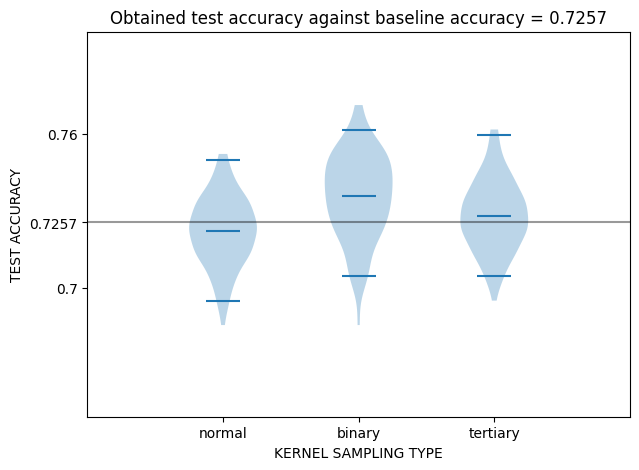

In [112]:
# Отрисуем доверительные интервалы 
plt.figure(figsize=(7, 5))
plt.violinplot(
    accuracy_histories.values(),
    showmeans=True,
    showextrema=False,
    quantiles=[[0.025, 0.9775] for _ in range(3)]
)
plt.hlines(0.7257, 0, 4, colors=["black"], alpha=0.4)

plt.xticks((1, 2, 3), labels=accuracy_histories.keys())
plt.yticks([0.7, 0.7257, 0.76], labels=["0.7", "0.7257", "0.76"])
plt.xlim(0, 4)
plt.ylim(0.65, 0.8)

plt.xlabel("KERNEL SAMPLING TYPE")
plt.ylabel("TEST ACCURACY")
plt.title("Obtained test accuracy against baseline accuracy = 0.7257")

plt.show()

Сравним полученные результаты для семплирования из нормального распределения с бейзлайном из статьи. Используем для этого одновыборочный t-критерий.

In [120]:
baseline_accuracy = 0.7257
print(ttest_1samp(accuracy_histories["normal"], baseline_accuracy))

TtestResult(statistic=-2.4352297926547046, pvalue=0.016671419339314486, df=99)


Критерий отклонил альтернативную гипотезу, следовательно для нормального распределения результат соответствует результату статьи. 

Сравним попарно результаты для разных методов семплирования с помощью двухвыборочного t-критерия.

In [123]:
for kst1, kst2 in combinations(accuracy_histories, 2):
    print(f"{kst1}, {kst2}: {ttest_ind(accuracy_histories[kst1], accuracy_histories[kst2]).pvalue}")

normal, binary: 2.1239273003639732e-09
normal, tertiary: 0.0022945649846516317
binary, tertiary: 0.0006352008319861447


Отличия между точностью моделей статистически значимы, при этом варианты с дискретным выбором показали улучшение по сравнению с семплированием из нормального распределения. Дополнительно заметим, что семплирование из 2 значений дало небольшой прирост по сравнению с семплированием из 3 значений.

Этот результат отличается от результатов авторов для так называемых 'development datasets' (Ham в них не входит), где разница между этими подходами оказалась не статитически значимой.